In [107]:
from pathlib import Path
import matplotlib
import math
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import sys
sys.path.append('../../../utility/python/')
from utility import (
    semi_join, anti_join, preprocess_web_logs_screen_name, complement_data,
    sub_days, plus_day, add_group_num, plot_two_axis_bar_line,plus_month
)
from utility import load_web_logs_from_bigquery, load_daily_user_logs_from_bigquery, load_data_from_db_with_script

In [108]:
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
data_dir_path = Path('data')
result_dir_path = Path('result')
if not data_dir_path.exists():
    data_dir_path.mkdir(parents=True)

In [110]:
target_day = '2022-11-03'
target_month = target_day[:7]

In [111]:
mazrica_domain_ids = [1, 8, 2095]
privilege_replace_dict = {1: '1_管理職', 2: '2_一般', 3: '2_一般'}
daily_user_logs_name_dict = {
    'deal_board': '案件ボード',
    'deals_table': '案件一覧',
    'actions_table': 'アクション一覧',
    'customers_table': '取引先一覧',
    'contacts_table': 'コンタクト一覧',
    'campaigns_table': 'キャンペーン一覧',
    'webforms_table': 'ウェブフォーム一覧',
    'custom_reports_table': 'カスタムレポート一覧',
    'dashboards_table': 'ダッシュボード一覧',
    'deal_page': '案件ページ',
    'action_page': 'アクションページ',
    'customer_page': '取引先ページ',
    'contact_page': 'コンタクトページ',
    'campaign_page': 'キャンペーンページ',
    'webform_page': 'ウェブフォームページ',
    'custom_report_page': 'カスタムレポートページ',
    'dashboard_page': 'ダッシュボードページ',
    'notification_modal_page': '通知モーダルページ',
    'reports': 'レポート系',
    'customer_merge_candidate': '名寄せ_取引先',
    'contact_merge_candidate': '名寄せ_コンタクト'
}

### データダウンロード

In [112]:
domain_user_maps = pd.read_csv('domain_user_maps.csv')
daily_user_logs = pd.read_csv(data_dir_path.joinpath('daily_user_logs.tsv'), sep='\t')

#### 前処理
マツリカユーザー削除・契約タイプ制限・dateをdatetime型へ変換

<span style="color: red; ">=」の間にスペースを入れる</span>

<span style="color: red; ">日付カラムは文字列のほうが扱いやすい</span>


In [113]:
dodomain_user_maps = anti_join(
    domain_user_maps, pd.DataFrame({'domain_id': mazrica_domain_ids}), by='domain_id'
).query('use_type == 30 or use_type == 40', engine='python')
daily_user_logs = daily_user_logs.assign(date=lambda x: x.date.astype(str)).sort_values(['date'])
domain_user_maps.head()


,domain_id,user_id,use_type,user_license,user_active,domain_active,privilege,contract_start_date,created_at
0,1,1,40.0,150,0,1,1,2016-01-01,2015-07-27 01:24:03
1,1,3,40.0,150,0,1,1,2016-01-01,2015-07-27 01:33:05
2,1,4,40.0,150,0,1,2,2016-01-01,2015-07-29 03:01:45
3,1,5,40.0,150,0,1,1,2016-01-01,2015-07-27 07:18:44
4,1,6,40.0,150,0,1,1,2016-01-01,2015-07-27 10:59:47


### DAUの集計

・<span style="color: red; ">「=」と「,」の間にスペースを入れる</span>

・<span style="color: red; ">「merge」の引数の「how」を省略しない</span>

In [114]:
dau_data = pd.merge(daily_user_logs, domain_user_maps, on='user_id', how='inner').query('login_web == 1', engine='python')
dau_data.head()

,date,user_id,login_web,login_mobile,deal_board,deals_table,actions_table,customers_table,contacts_table,campaigns_table,webforms_table,custom_reports_table,dashboards_table,deal_page,action_page,customer_page,contact_page,campaign_page,webform_page,custom_report_page,dashboard_page,notification_modal_page,reports,domain_id,use_type,user_license,user_active,domain_active,privilege,contract_start_date,created_at
0,2022-03-04,13787,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1635,40.0,640,1,1,2,2020-12-01,2021-04-27 04:26:20
1,2022-03-07,13787,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1635,40.0,640,1,1,2,2020-12-01,2021-04-27 04:26:20
2,2022-03-08,13787,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1635,40.0,640,1,1,2,2020-12-01,2021-04-27 04:26:20
3,2022-03-10,13787,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1635,40.0,640,1,1,2,2020-12-01,2021-04-27 04:26:20
4,2022-03-23,13787,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1635,40.0,640,1,1,2,2020-12-01,2021-04-27 04:26:20


### 全体

pandasのプロット関数は汎用性がないので、「matplotlib」か「seaborn」を使って、慣れる

In [115]:
plot_data = dau_data.groupby('date')['user_id'].nunique().reset_index().rename(columns={'user_id': 'dau'})

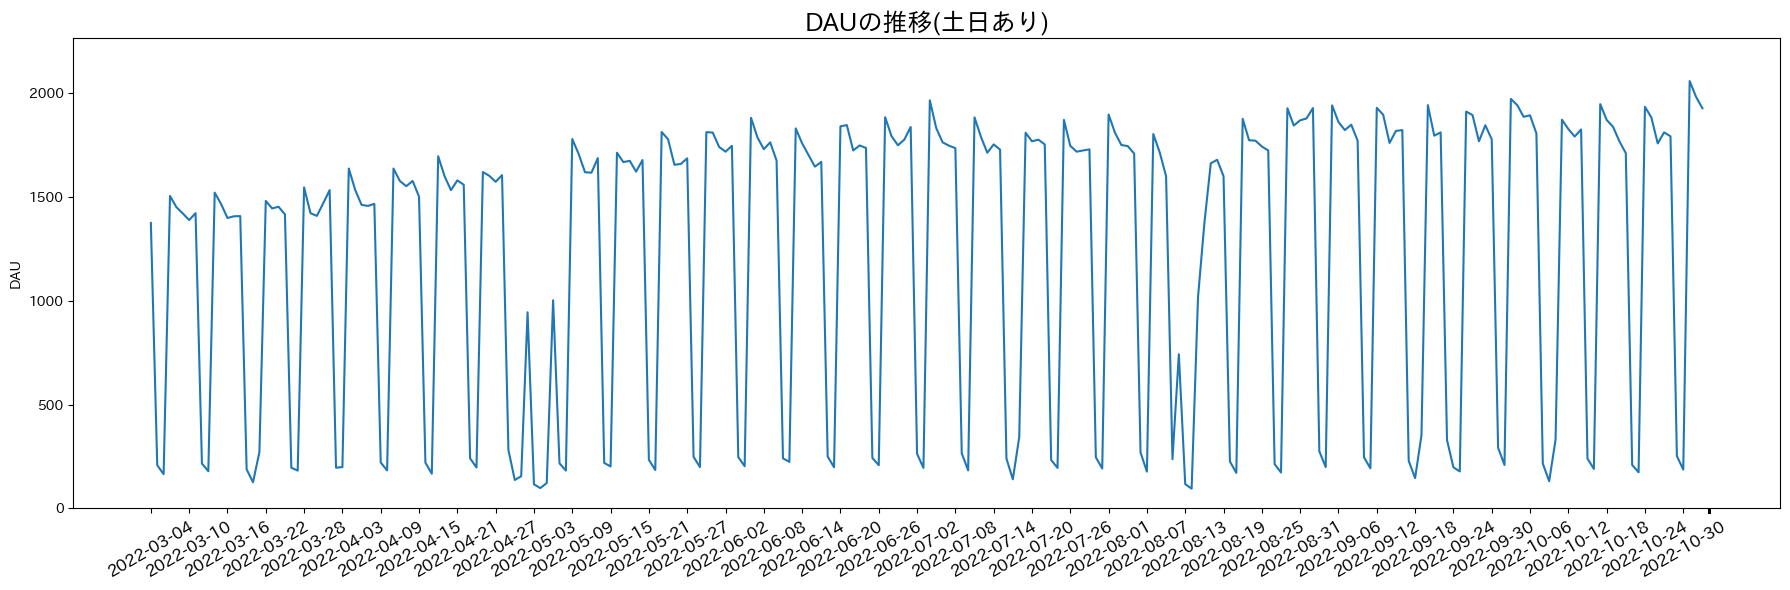

In [116]:
plt.figure(figsize=(18, 6), facecolor='white')
sns.lineplot(data=plot_data, x='date', y='dau')
plt.title('DAUの推移(土日あり)', fontsize=18, weight='bold')
plt.ylim(0, plot_data['dau'].max() * 1.1)
plt.xlabel('')
plt.ylabel('DAU')
xticklabels = plot_data['date'].tolist()
tmp = np.zeros(len(xticklabels))
tmp[np.arange(len(xticklabels)) % 6 == 0] = 1
xticklabels = np.where(tmp == 1, xticklabels, '')
plt.xticks(xticklabels, fontsize=12, rotation=30)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('dau_all.png'), dpi=300)

### 土日を省く

In [117]:
plot_data = dau_data.assign(
    weekday = lambda x: x.date.map(
        lambda y: dt.datetime.strptime(y, '%Y-%m-%d').weekday()
    )
).query('0 <= weekday <= 4', engine='python').groupby('date')['user_id'].nunique().reset_index().rename(columns={'user_id': 'dau'})

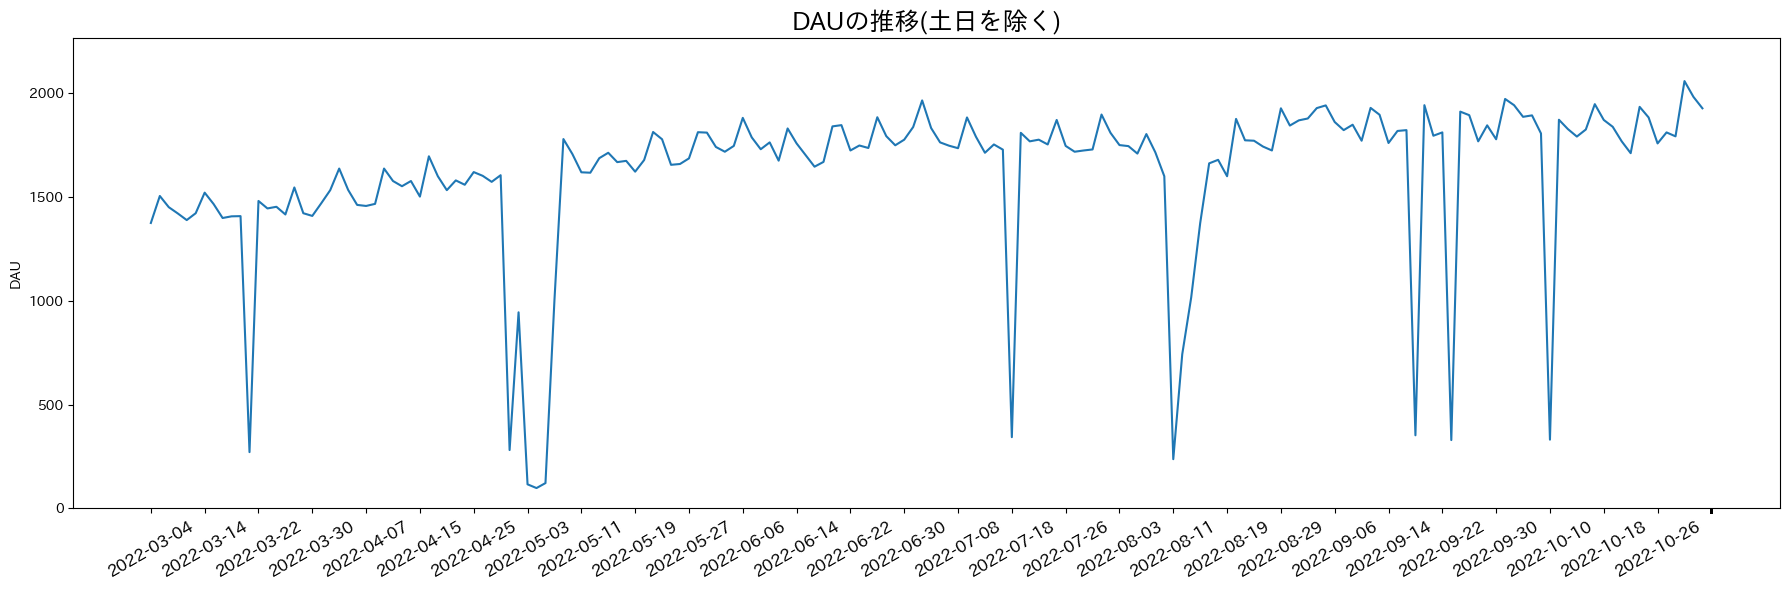

In [118]:
plt.figure(figsize=(18, 6), facecolor='white')
sns.lineplot(data=plot_data, x='date', y='dau')
plt.title('DAUの推移(土日を除く)', fontsize=18, weight='bold')
plt.ylim(0, plot_data['dau'].max() * 1.1)
plt.xlabel('')
plt.ylabel('DAU')
xticklabels = plot_data['date'].tolist()
tmp = np.zeros(len(xticklabels))
tmp[np.arange(len(xticklabels)) % 6 == 0] = 1
xticklabels = np.where(tmp == 1, xticklabels, '')
plt.xticks(xticklabels, fontsize=12, rotation=30)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('dau_excluding_holiday.png'), dpi=300)

### 祭日っぽい箇所を抜く


In [119]:
plot_data = dau_data.assign(
    weekday = lambda x: x.date.map(
        lambda y: dt.datetime.strptime(y, '%Y-%m-%d').weekday()
    )
).query('0 <= weekday <= 4', engine='python').groupby('date')['user_id'].nunique().reset_index().rename(columns={'user_id': 'dau'}).query(
    'dau >= 500', engine='python'
)

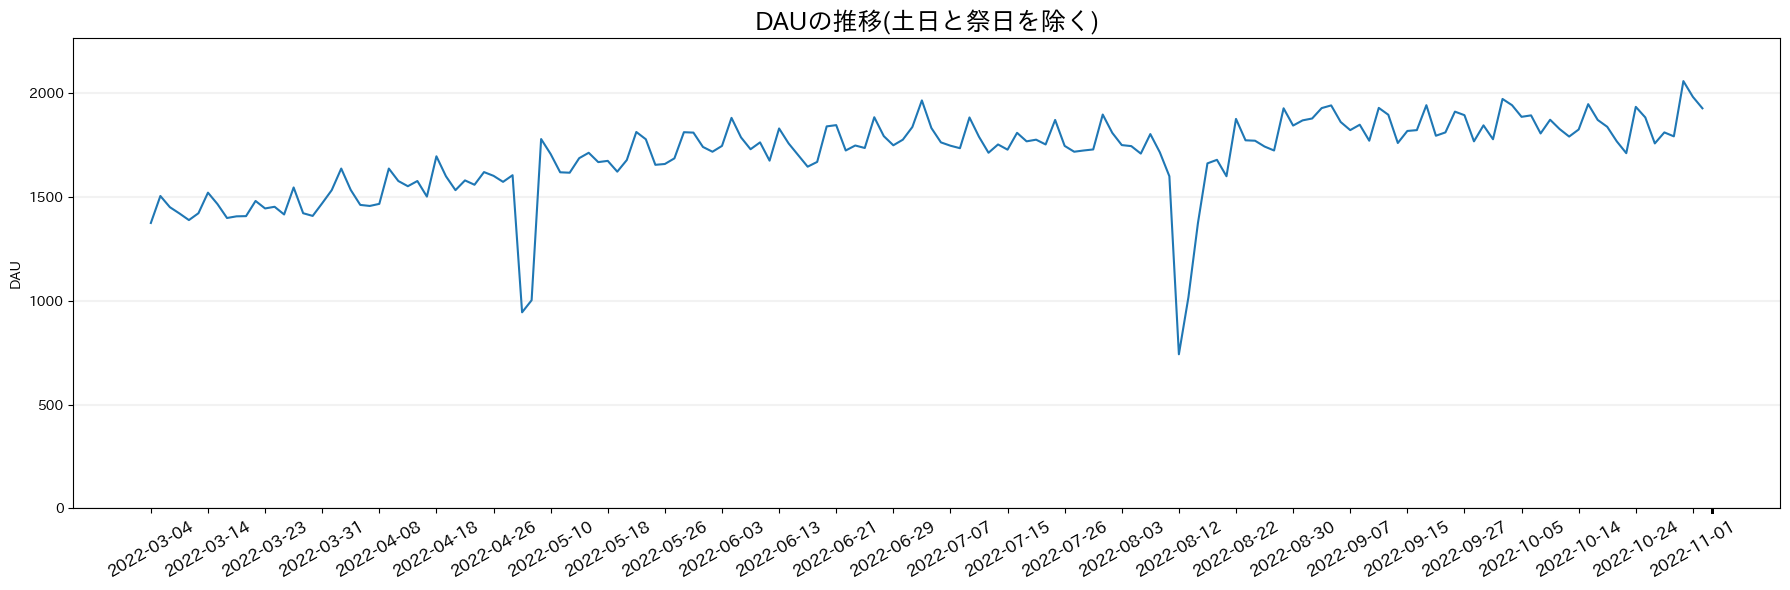

In [120]:

plt.figure(figsize=(18, 6), facecolor='white')
sns.lineplot(data=plot_data, x='date', y='dau')
plt.title('DAUの推移(土日と祭日を除く)', fontsize=18, weight='bold')
plt.ylim(0, plot_data['dau'].max() * 1.1)
plt.xlabel('')
plt.ylabel('DAU')
xticklabels = plot_data['date'].tolist()
tmp = np.zeros(len(xticklabels))
tmp[np.arange(len(xticklabels)) % 6 == 0] = 1
xticklabels = np.where(tmp == 1, xticklabels, '')
plt.xticks(xticklabels, fontsize=12, rotation=30)
plt.tight_layout()
for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)
plt.savefig(result_dir_path.joinpath('dau_excluding_national_holiday.png'), dpi=300)

### 管理者と一般

In [121]:
plot_data = pd.concat([
    dau_data.query('privilege == 1', engine='python').assign(user_type='管理者'),
    dau_data.query('privilege != 1', engine='python').assign(user_type='一般'),
], axis=0).assign(
    weekday = lambda x: x.date.map(
        lambda y:dt.datetime.strptime(y, '%Y-%m-%d').weekday()
    )
).query('0 <= weekday <= 4', engine = 'python').groupby(['date', 'user_type'])['user_id'].nunique().reset_index().rename(columns = {'user_id': 'dau'})

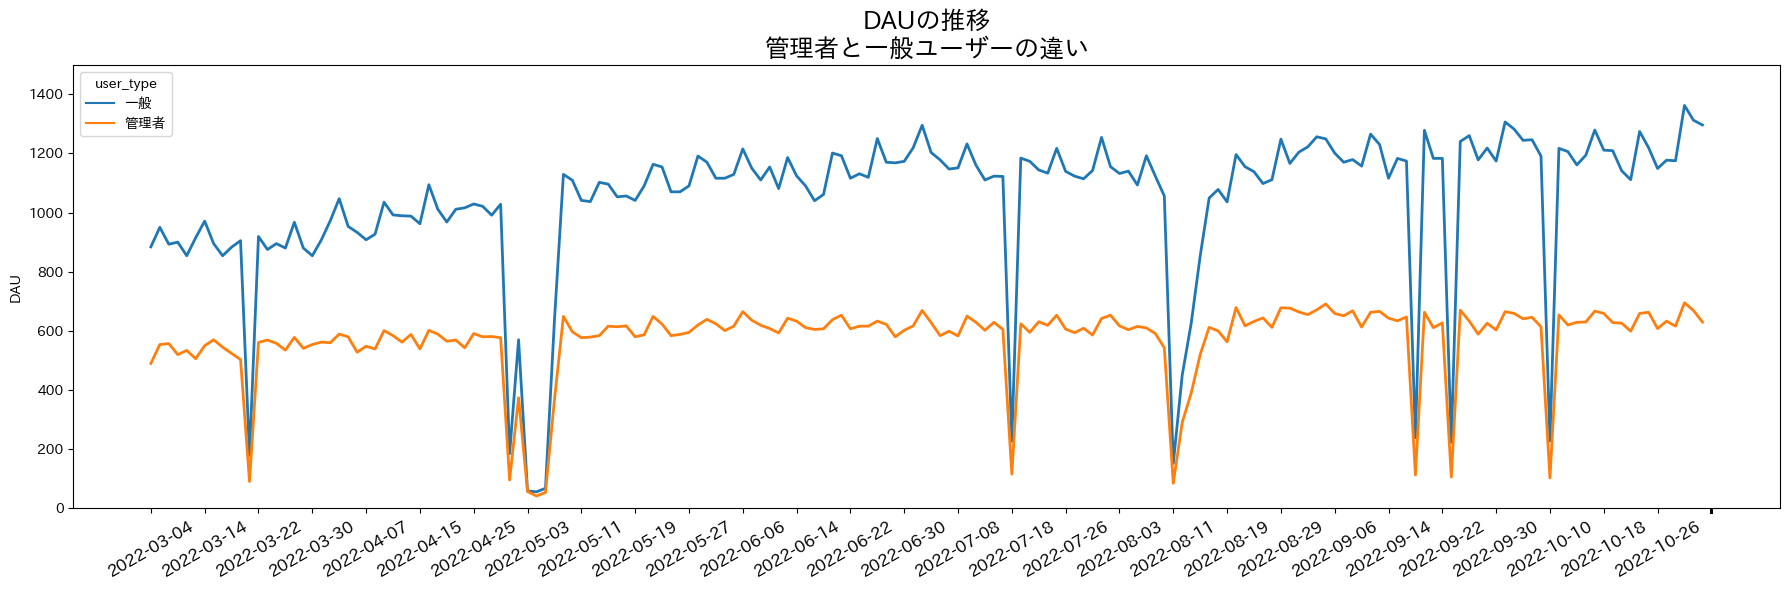

In [122]:
plt.figure(figsize = (18, 6), facecolor='white')
sns.lineplot(data=plot_data, x='date', y='dau', hue='user_type', lw=2)
plt.title('DAUの推移\n管理者と一般ユーザーの違い', fontsize=18, weight='bold')
plt.ylim(0, plot_data['dau'].max() * 1.1)
plt.xlabel('')
plt.ylabel('DAU')
xticklabels = plot_data['date'].unique().tolist()
tmp = np.zeros(len(xticklabels))
tmp[np.arange(len(xticklabels)) % 6 == 0] = 1
xticklabels = np.where(tmp == 1, xticklabels, '')
plt.xticks(xticklabels, fontsize=12, rotation=30)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('dau_privilege.png'), dpi=300)

### 曜日別ログインユーザー数

In [125]:
plot_data = dau_data.groupby('date')['user_id'].nunique().reset_index().rename(columns={'user_id': 'dau'})

plot_data["date"] = pd.to_datetime(plot_data["date"])
plot_data['week'] = plot_data.date.dt.weekday
plot_data = plot_data.groupby('week')['dau'].mean()

label_w = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']

plot_data.set_axis( label_w, axis="index", inplace=True)
data_w = pd.DataFrame(plot_data).assign(
    data_w = lambda x: x.dau.astype(str)
)

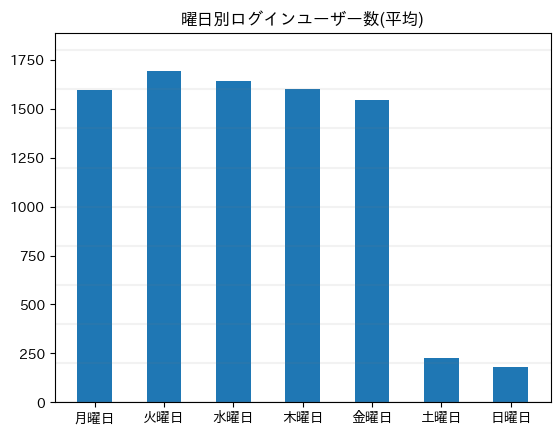

In [127]:
left = np.arange(len(label_w))
width = 0.3
plt.bar(left, data_w.dau, align="center",width=0.5)
plt.xticks(left , label_w)
plt.title('曜日別ログインユーザー数(平均)')
for tick in plt.yticks()[0]:
    plt.axhline(tick, color='grey', alpha=0.1)
plt.show()